In [218]:
import re,string

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

 
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk import punkt
from nltk.tag import pos_tag
from nltk.corpus import wordnet as wn

  
from string import punctuation
from collections import Counter
 
from collections import OrderedDict
import re
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

from afinn import Afinn
from wordcloud import WordCloud, STOPWORDS

from bs4 import BeautifulSoup


In [2]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn
from nltk import sent_tokenize, word_tokenize, pos_tag

In [470]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [3]:
porter = PorterStemmer()
wnl = WordNetLemmatizer() 
stop = stopwords.words('english')
stop.append("new")
stop.append("like")
stop.append("u")
stop.append("it'")
stop.append("'s")
stop.append("n't")
stop.append('mr.')
stop = set(stop)

In [4]:
def tokenizer(text):
 
    tokens_ = [word_tokenize(sent) for sent in sent_tokenize(text)]
 
    tokens = []
    for token_by_sent in tokens_:
        tokens += token_by_sent
 
    tokens = list(filter(lambda t: t.lower() not in stop, tokens))
    tokens = list(filter(lambda t: t not in punctuation, tokens))
    tokens = list(filter(lambda t: t not in [u"'s", u"n't", u"...", u"''", u'``', u'\u2014', u'\u2026', u'\u2013'], tokens))
     
    filtered_tokens = []
    for token in tokens:
        token = wnl.lemmatize(token)
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
 
    filtered_tokens = list(map(lambda token: token.lower(), filtered_tokens))
 
    return filtered_tokens

In [5]:
STEMMING = True  # judgment call, parsed documents more readable if False
MAX_NGRAM_LENGTH = 2  # try 1 and 2 and see which yields better modeling results
VECTOR_LENGTH = 100  # set vector length for TF-IDF and Doc2Vec

def pos_tag_text(tokens):
    #Convert Penn treebank tag to wordnet because lemmatize uses wordnet tags
    def penn_to_wn_tags(pos_tag):
        if pos_tag.startswith('J'):
            return wn.ADJ
        elif pos_tag.startswith('V'):
            return wn.VERB
        elif pos_tag.startswith('N'):
            return wn.NOUN
        elif pos_tag.startswith('R'):
            return wn.ADV
        else:
            return None
    
    
    #tokens=word_tokenize(text)
    tagged_text = pos_tag(tokens,tagset='universal')
    tagged_tokens = [(word, penn_to_wn_tags(pos_tag)) for word, pos_tag in tagged_text]
    return tagged_tokens

def lemmatize_pos_text(tokens):
    pos_tagged_text=pos_tag_text(tokens)
    lemmatized_tokens = [wnl.lemmatize(word, pos_tag) if pos_tag else word for word,pos_tag in pos_tagged_text]
#    lemmatized_text = ' '.join(lemmatized_tokens)
    return lemmatized_tokens

###############################################################################
### Function to process documents
###############################################################################
def clean_doc(doc): 
    # split document into individual words
    tokens=doc.split()
    
    tokens = lemmatize_pos_text(tokens)
    
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # # filter out short tokens
    tokens = [word for word in tokens if len(word) > 3]
    # #lowercase all words
    tokens = [word.lower() for word in tokens]
    # # filter out stop words
    custom_stop_words=['people','american','america','nation','congress']
    english_stop_words = (stopwords.words('english'))
    stopword_list=english_stop_words+custom_stop_words
    tokens = [w for w in tokens if not w in stopword_list]         
    # # word stemming Commented
    if STEMMING:
        ps=PorterStemmer()
        tokens=[ps.stem(word) for word in tokens]
    return tokens


In [6]:
def get_keywords(tokens, num):
    return Counter(tokens).most_common(num)

In [7]:
def build_text(text):
    review_text = []
    for index, row in text.iterrows():
        try:
            data=row['text'].strip().replace("'", "")
            #data = strip_tags(data)
            soup = BeautifulSoup(data , "lxml")
            data = soup.get_text()
            data = data.encode('ascii', 'ignore').decode('ascii')
            document = tokenizer(data)
           # document = clean_doc(data)
            top_15 = get_keywords(document, 500)
           # print(top_5)
            unzipped = next(zip(*top_15))
            kw= list(unzipped)
            kw=",".join(str(x) for x in kw)
            review_text.append((kw, row['business_id'], row['business_star_rating'],row['user_star_rating'],row['date'],row['categories']))
        except Exception as e:
            print(e)
            #print data
            #break
            pass
        #break
    review_text_df = pd.DataFrame(review_text, columns=['keywords', 'business_id', 'business_star_rating','user_star_rating','date','categories'])
    return review_text_df


In [61]:
business = pd.read_csv("C:/Users/Ric/Desktop/000_MY_WORKDIRECTORY/python/capstone yelp/business.csv")
#business.head(100)
business.count() #3244 cats, 3247 rest
#business.shape#3247 rows, 22 columns
#business.nunique()#68 cat, review_count 459
#business.isnull().sum()#3 null cats
#yrv

business_id                   3247
name                          3247
address                       3247
city                          3247
state                         3247
postal_code                   3247
latitude                      3247
longitude                     3247
stars                         3247
review_count                  3247
is_open                       3247
categories                    3247
cat                           3244
Fast Food                     3247
Bars                          3247
Gluten-Free                   3247
Vegetarian                    3247
Vegan                         3247
Pizza                         3247
temp                          3247
chain                         3247
ByAppointmentOnly             3221
BusinessAcceptsCreditCards    3221
BusinessParking_garage        3221
BusinessParking_street        3221
BusinessParking_validated     3221
BusinessParking_lot           3221
BusinessParking_valet         3221
RestaurantsPriceRang

In [9]:
business.loc[business[('review_count')].idxmax()]#Pizzeria Bianco, 2035 reviews, italian category

business_id                                       pSQFynH1VxkfSmehRXlZWw
name                                                   "Pizzeria Bianco"
address                                                 "623 E Adams St"
city                                                             Phoenix
state                                                                 AZ
postal_code                                                        85004
latitude                                                         33.4492
longitude                                                       -112.066
stars                                                                  4
review_count                                                        2035
is_open                                                                1
categories                    Restaurants;Salad;Pizza;Italian;Sandwiches
cat                                                              Italian
Fast Food                                          

In [10]:
business.loc[business[('review_count')].idxmin()]#Taco Bell, review count 3,cat Mexican

business_id                                  _cRDDAasE-4584eXN_5Ecw
name                                                    "Taco Bell"
address                                          "1004 N. 24th St."
city                                                        Phoenix
state                                                            AZ
postal_code                                                   85008
latitude                                                    33.4587
longitude                                                   -112.03
stars                                                           2.5
review_count                                                      3
is_open                                                           1
categories                    Tex-Mex;Restaurants;Mexican;Fast Food
cat                                                         Mexican
Fast Food                                                      True
Bars                                            

In [62]:
business['cat'].value_counts()

Mexican                      478
American (New)               317
Pizza                        274
Burgers                      255
Sandwiches                   221
Chinese                      165
Cafe                         163
Italian                      120
Coffee & Tea                  71
Sushi                         65
Chicken                       60
American (Traditional)        59
Ice Cream & Frozen Yogurt     57
Diners                        50
Barbeque                      48
Greek                         47
Sports Bar                    47
Burger                        40
Thai                          39
Wine Bars                     39
Cocktail Bars                 39
Steakhouses                   37
Deli                          37
Vietnamese                    36
Indian                        28
Japanese                      27
Asian Fusion                  26
Juice Bars & Smoothies        26
Seafood                       22
Bagels                        20
          

In [63]:
revcount = business.groupby('cat', as_index=False)['review_count'].sum()
#revcount.sort_values['review_count']#mexican -39193, american(new) - 31242,
revcount#mexican -39193, american(new) - 31242,

,cat,review_count
0,Afghan,104
1,African,349
2,American (New),31242
3,American (Traditional),5396
4,Asian Fusion,3923
5,Bagels,1304
6,Bakeries,437
7,Barbeque,5373
8,Bars,1949
9,Breakfast & Brunch,2699


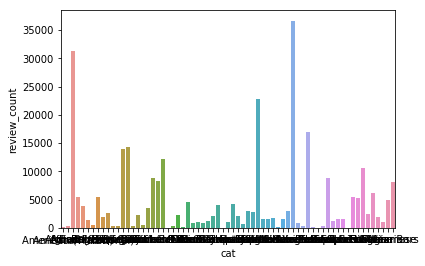

In [64]:
ax = sns.barplot(x="cat", y="review_count", data=revcount)

In [14]:
reviews = pd.read_csv("C:/Users/Ric/Desktop/000_MY_WORKDIRECTORY/python/capstone yelp/yelp_review.csv")
#reviews.count()
#reviews['text'].head(100)
reviews.nunique()

review_id      5261668
user_id        1326101
business_id     174567
stars                5
date              4547
text           5258354
useful             294
funny              255
cool               187
dtype: int64

In [15]:
reviews.nunique()
reviews.isnull().sum()

review_id      0
user_id        0
business_id    0
stars          0
date           0
text           0
useful         0
funny          0
cool           0
dtype: int64

In [16]:
#busreview = pd.merge(business,reviews,on='business_id', how = 'left')##not needed..merge review and business after merging 
##tip and review
#busreview.count()#yelpbusreview.head(15) #294858
#yelpbusreview.nunique()

business_id                   294858
name                          294858
address                       294858
city                          294858
state                         294858
postal_code                   294858
latitude                      294858
longitude                     294858
stars_x                       294858
review_count                  294858
is_open                       294858
categories                    294858
cat                           294841
Fast Food                     294858
Bars                          294858
Gluten-Free                   294858
Vegetarian                    294858
Vegan                         294858
Pizza                         294858
temp                          294858
chain                         294858
ByAppointmentOnly             294703
BusinessAcceptsCreditCards    294703
BusinessParking_garage        294703
BusinessParking_street        294703
BusinessParking_validated     294703
BusinessParking_lot           294703
B

In [17]:
#busreview.isnull().sum()#17 cats are null
#busreview.rename(columns={'name':'business_name','stars_x':'business_star_rating','stars_y':'user_star_rating'})

,business_id,business_name,address,city,state,postal_code,latitude,longitude,business_star_rating,review_count,...,weekday_late_night,weekend_late_night,review_id,user_id,user_star_rating,date,text,useful,funny,cool
0,__aKnGBedQ51_hEc3D9ARw,"""Paradise Bakery & Cafe""","""2502 E Camelback Rd, Ste 119""",Phoenix,AZ,85016,33.510270,-112.028937,3.0,75,...,0,0,nGPemoNcDPEZUo2jbD6W1Q,NwxF1Ftc-4P5Pl_SSXThQA,2,2013-10-02,Skip PB and try True Food instead!\n\nToo bad ...,0,0,0
1,__aKnGBedQ51_hEc3D9ARw,"""Paradise Bakery & Cafe""","""2502 E Camelback Rd, Ste 119""",Phoenix,AZ,85016,33.510270,-112.028937,3.0,75,...,0,0,m9PNVNUxZNhyTXRFCWikPg,EOxdQuedwe_2MkdLnX7MAA,3,2013-04-23,"I love their salads and soups! \n\nYes, Paradi...",2,0,0
2,__aKnGBedQ51_hEc3D9ARw,"""Paradise Bakery & Cafe""","""2502 E Camelback Rd, Ste 119""",Phoenix,AZ,85016,33.510270,-112.028937,3.0,75,...,0,0,wE-DaBBGIbVOHGGZ4700pQ,cNkofgeZTGNkmw8m5jR8LA,3,2014-02-06,I always get a thai chicken salad when I come ...,0,0,0
3,__aKnGBedQ51_hEc3D9ARw,"""Paradise Bakery & Cafe""","""2502 E Camelback Rd, Ste 119""",Phoenix,AZ,85016,33.510270,-112.028937,3.0,75,...,0,0,aud3jxxba0Z4OIeBjFPYyQ,LRh7vAnTwvlO0yHP12rxRg,3,2014-03-18,When you walk in the door of the Biltmore loca...,2,1,0
4,__aKnGBedQ51_hEc3D9ARw,"""Paradise Bakery & Cafe""","""2502 E Camelback Rd, Ste 119""",Phoenix,AZ,85016,33.510270,-112.028937,3.0,75,...,0,0,4HiH3KtKsk5oFacrlFSajw,pCYGQH-b7YkdR5wT8kvipA,1,2015-01-14,"This is one of the few ""affordable"" lunch opti...",5,2,0
5,__aKnGBedQ51_hEc3D9ARw,"""Paradise Bakery & Cafe""","""2502 E Camelback Rd, Ste 119""",Phoenix,AZ,85016,33.510270,-112.028937,3.0,75,...,0,0,fw_6yyyy01al391t-m1spA,NWuFF7-HjYE9dvt_xGbEhw,1,2012-02-28,Won't ever come back here again! I came in and...,4,2,0
6,__aKnGBedQ51_hEc3D9ARw,"""Paradise Bakery & Cafe""","""2502 E Camelback Rd, Ste 119""",Phoenix,AZ,85016,33.510270,-112.028937,3.0,75,...,0,0,DtvvqcmagutrFpprdJ-A6w,pf7pB-UbvKT-AWfQcg6kBg,4,2009-05-28,I just can't get enough of this place. I know ...,0,0,0
7,__aKnGBedQ51_hEc3D9ARw,"""Paradise Bakery & Cafe""","""2502 E Camelback Rd, Ste 119""",Phoenix,AZ,85016,33.510270,-112.028937,3.0,75,...,0,0,jl_smfbQ4BFLxYiguZo_Yg,MD8nhQkHlRtulzPwDOdlcA,1,2014-02-24,For the love of all that is good and right in ...,4,4,1
8,__aKnGBedQ51_hEc3D9ARw,"""Paradise Bakery & Cafe""","""2502 E Camelback Rd, Ste 119""",Phoenix,AZ,85016,33.510270,-112.028937,3.0,75,...,0,0,unm097CkbAMQmNFMU1UFRA,mjBN1BCG8ChnNMDTrf7kgQ,1,2015-09-21,"I'll keep it quick, you forgot some of our foo...",2,1,1
9,__aKnGBedQ51_hEc3D9ARw,"""Paradise Bakery & Cafe""","""2502 E Camelback Rd, Ste 119""",Phoenix,AZ,85016,33.510270,-112.028937,3.0,75,...,0,0,MpqCNuVCvK9Q2lhOPJ4Z6Q,vBSzgSvcawxtaDuIdi9hCA,4,2015-11-30,A great office away from home. They cater to t...,3,0,2


In [48]:
##combining reviews of users for a same business id by date
#busreview.groupby(['user_id','business_id', 'date'])['text'].apply(lambda x: ','.join(x)).reset_index()

,user_id,business_id,date,text
0,---cu1hq55BP9DWVXXKHZg,EGzsR_Tyd0QOaZ6g7wPl-w,2014-11-19,Went to this location on 11\/19\/2014. Its not...
1,---cu1hq55BP9DWVXXKHZg,eCJDiRPoSuA0bsb7F1gNUA,2014-11-20,"Somehow 11111 N 7th Street is ""too far for us...."
2,--2HUmLkcNHZp0xw6AMBPg,042IHd5KjHiMuBtGtugO_g,2017-06-17,"Great beers, good food, and fun ambiance."
3,--2HUmLkcNHZp0xw6AMBPg,Xg5qEQiB-7L6kGJ5F4K3bQ,2017-06-28,Amazing. Worth the wait 100%!
4,--2HUmLkcNHZp0xw6AMBPg,mnwRtuVQEsIUomBchu0gwg,2017-06-17,Cool location - solid food.
5,--2HUmLkcNHZp0xw6AMBPg,yX0pOWG_Be9TjGnm0aihVA,2017-06-17,Obsessed with their chicken salad and sweet fr...
6,--3WaS23LcIXtxyFULJHTA,mnwRtuVQEsIUomBchu0gwg,2012-12-02,Back patio has a nice view of the mountain
7,--3WaS23LcIXtxyFULJHTA,wB2mrl_xHyj55UObucaVRA,2016-09-06,What a surprise Ollie Vaughns is for the locat...
8,--41c9Tl0C9OGewIR7Qyzg,ey3i64kDG-91Zqz6LCH14Q,2012-01-13,"Over by gate A7, right next to Barfly!"
9,--41c9Tl0C9OGewIR7Qyzg,ey3i64kDG-91Zqz6LCH14Q,2012-01-14,The location of this place is nice (over in Te...


In [20]:
tips = pd.read_csv("C:/Users/Ric/Desktop/000_MY_WORKDIRECTORY/python/capstone yelp/yelp_tip.csv")
tips.head()

,text,date,likes,business_id,user_id
0,Great breakfast large portions and friendly wa...,2015-08-12,0,jH19V2I9fIslnNhDzPmdkA,ZcLKXikTHYOnYt5VYRO5sg
1,Nice place. Great staff. A fixture in the tow...,2014-06-20,0,dAa0hB2yrnHzVmsCkN4YvQ,oaYhjqBbh18ZhU0bpyzSuw
2,Happy hour 5-7 Monday - Friday,2016-10-12,0,dAa0hB2yrnHzVmsCkN4YvQ,ulQ8Nyj7jCUR8M83SUMoRQ
3,"Parking is a premium, keep circling, you will ...",2017-01-28,0,ESzO3Av0b1_TzKOiqzbQYQ,ulQ8Nyj7jCUR8M83SUMoRQ
4,Homemade pasta is the best in the area,2017-02-25,0,k7WRPbDd7rztjHcGGkEjlw,ulQ8Nyj7jCUR8M83SUMoRQ


In [22]:
business_ids = business.business_id.unique().tolist()
len(business_ids) # 3241

3247

In [27]:
tip=tips[tips.business_id.isin(business_ids)]
review = reviews[reviews.business_id.isin(business_ids)]
review.count()

review_id      294858
user_id        294858
business_id    294858
stars          294858
date           294858
text           294858
useful         294858
funny          294858
cool           294858
dtype: int64

In [221]:
tips.count()

text           1098322
date           1098324
likes          1098324
business_id    1098324
user_id        1098324
dtype: int64

In [36]:
tip=tips[tips.business_id.isin(business_ids)]
tip.count()

text           72495
date           72495
likes          72495
business_id    72495
user_id        72495
dtype: int64

In [35]:
tipreview = review.append(tip,ignore_index=True)
tipreview.count()

business_id    367353
cool           294858
date           367353
funny          294858
likes           72495
review_id      294858
stars          294858
text           367353
useful         294858
user_id        367353
dtype: int64

In [65]:
#tipreview.groupby(['user_id','business_id', 'date'])['text'].apply(lambda x: ','.join(x)).reset_index()
#tipreview.count()
bustipreview = pd.merge(business,tipreview,on='business_id', how = 'left')
bustipreview.count()#367353

business_id                   367353
name                          367353
address                       367353
city                          367353
state                         367353
postal_code                   367353
latitude                      367353
longitude                     367353
stars_x                       367353
review_count                  367353
is_open                       367353
categories                    367353
cat                           367333
Fast Food                     367353
Bars                          367353
Gluten-Free                   367353
Vegetarian                    367353
Vegan                         367353
Pizza                         367353
temp                          367353
chain                         367353
ByAppointmentOnly             367179
BusinessAcceptsCreditCards    367179
BusinessParking_garage        367179
BusinessParking_street        367179
BusinessParking_validated     367179
BusinessParking_lot           367179
B

In [67]:
bustipreview = bustipreview.rename(columns={'name':'business_name','stars_x':'business_star_rating','stars_y':'user_star_rating'})
bustipreview.drop(['cool','funny','likes','useful'],axis=1)

,business_id,business_name,address,city,state,postal_code,latitude,longitude,business_star_rating,review_count,...,weekend_lunch,weekday_dinner,weekend_dinner,weekday_late_night,weekend_late_night,date,review_id,user_star_rating,text,user_id
0,__aKnGBedQ51_hEc3D9ARw,"""Paradise Bakery & Cafe""","""2502 E Camelback Rd, Ste 119""",Phoenix,AZ,85016,33.510270,-112.028937,3.0,75,...,1,1,1,0,0,2013-10-02,nGPemoNcDPEZUo2jbD6W1Q,2.0,Skip PB and try True Food instead!\n\nToo bad ...,NwxF1Ftc-4P5Pl_SSXThQA
1,__aKnGBedQ51_hEc3D9ARw,"""Paradise Bakery & Cafe""","""2502 E Camelback Rd, Ste 119""",Phoenix,AZ,85016,33.510270,-112.028937,3.0,75,...,1,1,1,0,0,2013-04-23,m9PNVNUxZNhyTXRFCWikPg,3.0,"I love their salads and soups! \n\nYes, Paradi...",EOxdQuedwe_2MkdLnX7MAA
2,__aKnGBedQ51_hEc3D9ARw,"""Paradise Bakery & Cafe""","""2502 E Camelback Rd, Ste 119""",Phoenix,AZ,85016,33.510270,-112.028937,3.0,75,...,1,1,1,0,0,2014-02-06,wE-DaBBGIbVOHGGZ4700pQ,3.0,I always get a thai chicken salad when I come ...,cNkofgeZTGNkmw8m5jR8LA
3,__aKnGBedQ51_hEc3D9ARw,"""Paradise Bakery & Cafe""","""2502 E Camelback Rd, Ste 119""",Phoenix,AZ,85016,33.510270,-112.028937,3.0,75,...,1,1,1,0,0,2014-03-18,aud3jxxba0Z4OIeBjFPYyQ,3.0,When you walk in the door of the Biltmore loca...,LRh7vAnTwvlO0yHP12rxRg
4,__aKnGBedQ51_hEc3D9ARw,"""Paradise Bakery & Cafe""","""2502 E Camelback Rd, Ste 119""",Phoenix,AZ,85016,33.510270,-112.028937,3.0,75,...,1,1,1,0,0,2015-01-14,4HiH3KtKsk5oFacrlFSajw,1.0,"This is one of the few ""affordable"" lunch opti...",pCYGQH-b7YkdR5wT8kvipA
5,__aKnGBedQ51_hEc3D9ARw,"""Paradise Bakery & Cafe""","""2502 E Camelback Rd, Ste 119""",Phoenix,AZ,85016,33.510270,-112.028937,3.0,75,...,1,1,1,0,0,2012-02-28,fw_6yyyy01al391t-m1spA,1.0,Won't ever come back here again! I came in and...,NWuFF7-HjYE9dvt_xGbEhw
6,__aKnGBedQ51_hEc3D9ARw,"""Paradise Bakery & Cafe""","""2502 E Camelback Rd, Ste 119""",Phoenix,AZ,85016,33.510270,-112.028937,3.0,75,...,1,1,1,0,0,2009-05-28,DtvvqcmagutrFpprdJ-A6w,4.0,I just can't get enough of this place. I know ...,pf7pB-UbvKT-AWfQcg6kBg
7,__aKnGBedQ51_hEc3D9ARw,"""Paradise Bakery & Cafe""","""2502 E Camelback Rd, Ste 119""",Phoenix,AZ,85016,33.510270,-112.028937,3.0,75,...,1,1,1,0,0,2014-02-24,jl_smfbQ4BFLxYiguZo_Yg,1.0,For the love of all that is good and right in ...,MD8nhQkHlRtulzPwDOdlcA
8,__aKnGBedQ51_hEc3D9ARw,"""Paradise Bakery & Cafe""","""2502 E Camelback Rd, Ste 119""",Phoenix,AZ,85016,33.510270,-112.028937,3.0,75,...,1,1,1,0,0,2015-09-21,unm097CkbAMQmNFMU1UFRA,1.0,"I'll keep it quick, you forgot some of our foo...",mjBN1BCG8ChnNMDTrf7kgQ
9,__aKnGBedQ51_hEc3D9ARw,"""Paradise Bakery & Cafe""","""2502 E Camelback Rd, Ste 119""",Phoenix,AZ,85016,33.510270,-112.028937,3.0,75,...,1,1,1,0,0,2015-11-30,MpqCNuVCvK9Q2lhOPJ4Z6Q,4.0,A great office away from home. They cater to t...,vBSzgSvcawxtaDuIdi9hCA


In [68]:
bustipreview.dtypes

business_id                    object
business_name                  object
address                        object
city                           object
state                          object
postal_code                     int64
latitude                      float64
longitude                     float64
business_star_rating          float64
review_count                    int64
is_open                         int64
categories                     object
cat                            object
Fast Food                        bool
Bars                             bool
Gluten-Free                      bool
Vegetarian                       bool
Vegan                            bool
Pizza                            bool
temp                             bool
chain                            bool
ByAppointmentOnly              object
BusinessAcceptsCreditCards     object
BusinessParking_garage         object
BusinessParking_street         object
BusinessParking_validated      object
BusinessPark

In [259]:
revcount = bustipreview.groupby('cat', as_index=False)['review_count'].sum().reset_index().sort_values('review_count', ascending=False)
#revcount.sort_values['review_count']#mexican -39193, american(new) - 31242,
revcount#mexican -39193, american(new) - 31242,
type(revcount)
revcount.to_csv('C:/Users/Ric/Desktop/000_MY_WORKDIRECTORY/python/capstone yelp/reviewcountbycategory.csv',sep=',',index= False)

In [260]:
revcount

,index,cat,review_count
46,46,Mexican,18893370
39,39,Italian,16581475
2,2,American (New),12737431
20,20,Coffee & Tea,9415906
66,66,Wine Bars,5447340
13,13,Cafe,5430978
60,60,Sushi,5060839
49,49,Pizza,4783028
12,12,Burgers,4400705
19,19,Cocktail Bars,3853765


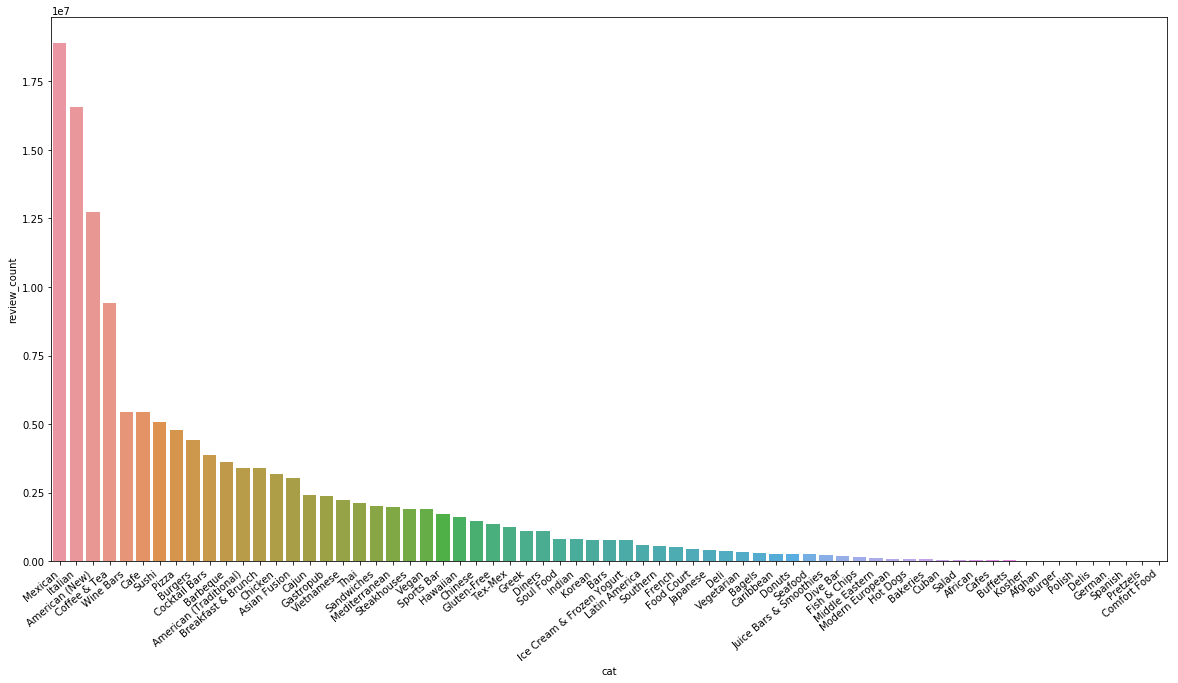

In [261]:
plt.figure(figsize=(20,10))
ax = sns.barplot(x="cat", y="review_count", data=revcount)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.savefig("C:/Users/Ric/Desktop/000_MY_WORKDIRECTORY/python/capstone yelp/review_countByCat.png")

In [239]:
ax1 = sns.count(x="cat", y="review_count", data=revcount, order=revcount['review_count'].value_counts().index)

AttributeError: module 'seaborn' has no attribute 'count'

In [173]:
busidmaxtipreview=bustipreview.loc[bustipreview[('review_count')].idxmax()]['business_id']#Pizzeria Bianco, 2035 reviews, italian category
busidmintipreview=bustipreview.loc[bustipreview[('review_count')].idxmin()]['business_id']


In [161]:
busidmaxtipreview

'pSQFynH1VxkfSmehRXlZWw'

In [174]:
bustipreviewmaxdf=bustipreview.loc[bustipreview['business_id']==busidmaxtipreview]
bustipreviewmindf=bustipreview.loc[bustipreview['business_id']==busidmintipreview]

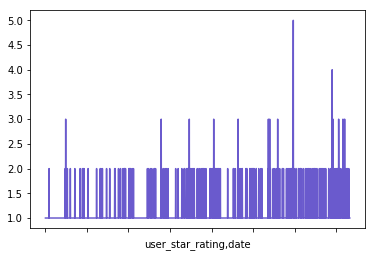

In [255]:
(bustipreviewmaxdf.groupby(['user_star_rating','date']).size()).plot(color =  'slateblue')
plt.savefig("C:/Users/Ric/Desktop/000_MY_WORKDIRECTORY/python/capstone yelp/maxreviewbus_userratingdistrib.png")

In [271]:
bustipreview5star = bustipreview.loc[bustipreview['business_star_rating']==5]
bustipreview1star = bustipreview.loc[bustipreview['business_star_rating']==1]
bustipreview2star = bustipreview.loc[bustipreview['business_star_rating']==2]
bustipreview3star = bustipreview.loc[bustipreview['business_star_rating']==3]
bustipreview4star = bustipreview.loc[bustipreview['business_star_rating']==4]

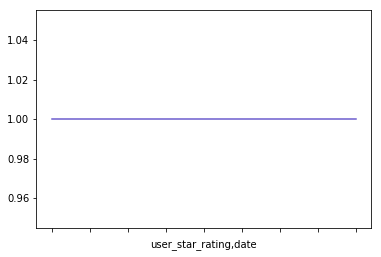

In [256]:
(bustipreviewmindf.groupby(['user_star_rating','date']).size()).plot(color =  'slateblue')
plt.savefig("C:/Users/Ric/Desktop/000_MY_WORKDIRECTORY/python/capstone yelp/minreviewbus_userratingdistrib.png")

In [132]:
bustipreview.loc[bustipreview[('review_count')].idxmax()]#Pizzeria Bianco, 2035 reviews, italian category

business_id                                              pSQFynH1VxkfSmehRXlZWw
business_name                                                 "Pizzeria Bianco"
address                                                        "623 E Adams St"
city                                                                    Phoenix
state                                                                        AZ
postal_code                                                               85004
latitude                                                                33.4492
longitude                                                              -112.066
business_star_rating                                                          4
review_count                                                               2035
is_open                                                                       1
categories                           Restaurants;Salad;Pizza;Italian;Sandwiches
cat                                     

In [131]:
businessratinggroup =bustipreview['business_id'].groupby(bustipreview['business_star_rating']).apply(lambda x: ','.join(x)).reset_index()# == busidmaxtipreview]


In [57]:
#users = pd.read_csv("C:/Users/Ric/Desktop/000_MY_WORKDIRECTORY/python/capstone yelp/yelp_user.csv")
users.count()
users.head(100)
users.nunique()

user_id               1326100
name                   113960
review_count             1719
yelping_since            4699
friends                748104
useful                   4026
funny                    2891
cool                     3461
fans                      529
elite                    8413
average_stars             400
compliment_hot           1295
compliment_more           339
compliment_profile        333
compliment_cute           340
compliment_list           197
compliment_note           934
compliment_plain         1491
compliment_cool          1502
compliment_funny         1502
compliment_writer         804
compliment_photos         795
dtype: int64

In [134]:
bustipreview_df = bustipreview[['business_id','business_star_rating','user_star_rating','date','text','cat','user_id']]
#bustipreview_df = busin[['business_id','text','cat']]

In [135]:
bustipreview_df

,business_id,business_star_rating,user_star_rating,date,text,cat,user_id
0,__aKnGBedQ51_hEc3D9ARw,3.0,2.0,2013-10-02,Skip PB and try True Food instead!\n\nToo bad ...,Cafe,NwxF1Ftc-4P5Pl_SSXThQA
1,__aKnGBedQ51_hEc3D9ARw,3.0,3.0,2013-04-23,"I love their salads and soups! \n\nYes, Paradi...",Cafe,EOxdQuedwe_2MkdLnX7MAA
2,__aKnGBedQ51_hEc3D9ARw,3.0,3.0,2014-02-06,I always get a thai chicken salad when I come ...,Cafe,cNkofgeZTGNkmw8m5jR8LA
3,__aKnGBedQ51_hEc3D9ARw,3.0,3.0,2014-03-18,When you walk in the door of the Biltmore loca...,Cafe,LRh7vAnTwvlO0yHP12rxRg
4,__aKnGBedQ51_hEc3D9ARw,3.0,1.0,2015-01-14,"This is one of the few ""affordable"" lunch opti...",Cafe,pCYGQH-b7YkdR5wT8kvipA
5,__aKnGBedQ51_hEc3D9ARw,3.0,1.0,2012-02-28,Won't ever come back here again! I came in and...,Cafe,NWuFF7-HjYE9dvt_xGbEhw
6,__aKnGBedQ51_hEc3D9ARw,3.0,4.0,2009-05-28,I just can't get enough of this place. I know ...,Cafe,pf7pB-UbvKT-AWfQcg6kBg
7,__aKnGBedQ51_hEc3D9ARw,3.0,1.0,2014-02-24,For the love of all that is good and right in ...,Cafe,MD8nhQkHlRtulzPwDOdlcA
8,__aKnGBedQ51_hEc3D9ARw,3.0,1.0,2015-09-21,"I'll keep it quick, you forgot some of our foo...",Cafe,mjBN1BCG8ChnNMDTrf7kgQ
9,__aKnGBedQ51_hEc3D9ARw,3.0,4.0,2015-11-30,A great office away from home. They cater to t...,Cafe,vBSzgSvcawxtaDuIdi9hCA


In [137]:
bustipreview_df.count()

business_id             367353
business_star_rating    367353
user_star_rating        294858
date                    367353
text                    367353
cat                     367333
user_id                 367353
dtype: int64

In [140]:
bustipreview_df.nunique()

business_id               3247
business_star_rating         9
user_star_rating             5
date                      4148
text                    364143
cat                         67
user_id                 122130
dtype: int64

In [ ]:
#data = []
#for index, row in yelpbustipreview_df.iterrows():
  #  data.append((row['business_id'], row['stars_x'], row['stars_y'], row['date'],row['text'],row['cat'],row['user_id']))
#yelprev_df = pd.DataFrame(data, columns=['business_id' ,'stars_x','stars_y', 'date', 'text' ,'cat','user_id'])


In [137]:
#yelpyelprev_df1 = yelprev1[1:200]

In [151]:
bustipreview_df.groupby(['business_id'])['text'].apply(lambda x: ','.join(x)).reset_index()

,business_id,text
0,-050d_XIor1NpCuWkbIVaQ,So until today I didn't know there was a lot o...
1,-0WegMt6Cy966qlDKhu6jA,I noticed that there were a few positive revie...
2,-0aIra_B6iALlfqAriBSYA,"If you like iced tea, this is the place to go!..."
3,-0tgMGl7D9B10YjSN2ujLA,My wife had the chicken boxty and I had the Sh...
4,-1UMR00eXtwaeh59pEiDjA,"First time at the airport in Phoenix, and Matt..."
5,-2isRNVb6PDuBagELL5EBw,It's a Taco Bell so if your expecting a detail...
6,-8JaNeG3etLgOVyg2gOIiA,We LOVED La Fontanella and were so sad to hear...
7,-9eNGMp8XiygI8t8QFuFWw,My husband and I had a gift card and decided t...
8,-Bdw-5H5C4AYSMGnAvmnzw,"I've only been to Tuck Shop once, after having..."
9,-BxWyEIQ6wypT-37MzZizQ,A few friends and I visited Carly's on a whim ...


In [195]:
bustipreviewmaxdf.groupby(['text','date'], as_index = False).size()


text                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

In [262]:
stop_words = ["restaurant", "people", "food", "place", "another", "asked", "us", "know","will","food","right","said",
             "got","explained", "phoenix"] + list(STOPWORDS)

stopwords =set(stop_words) 


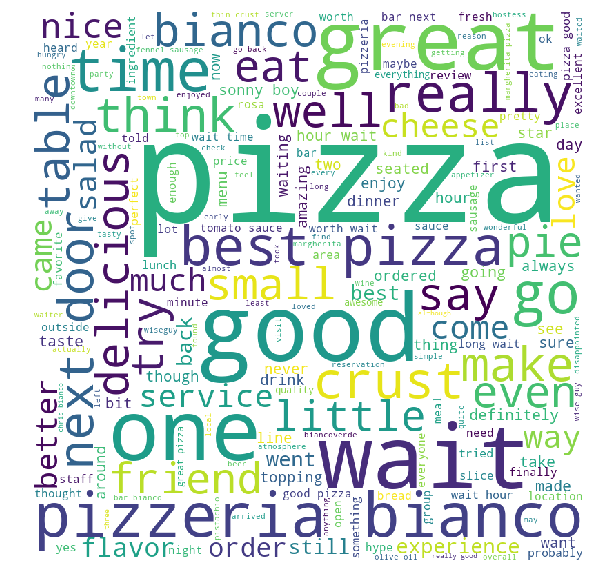

In [263]:
comment_words = ' '
#stopwords =set(STOPWORDS) 

# iterate through the csv file 
for val in bustipreviewmaxdf.text: 
    # typecaste each val to string 
    val = str(val) 

    # split the value 
    tokens = val.split()
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
    
    for words in tokens: 
        comment_words = comment_words + words + ' '

wordcloud = WordCloud(width = 800, height = 800,
                      background_color ='white',
                      stopwords=stopwords,
                      min_font_size = 10).generate(comment_words)
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0)
plt.show()

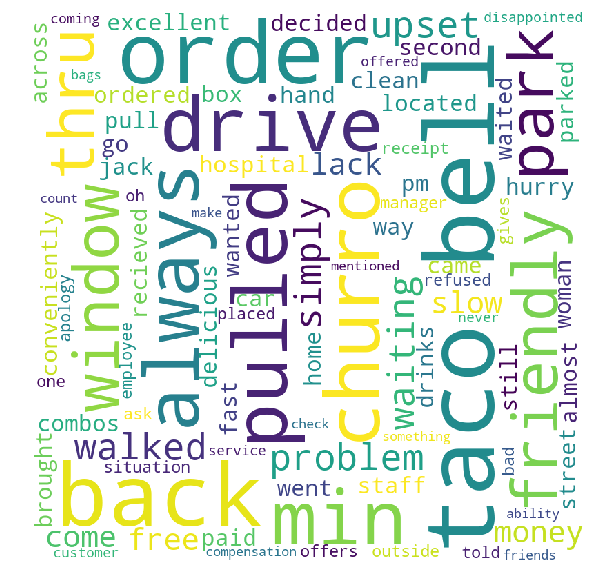

In [265]:
comment_words = ' '
#stopwords =set(STOPWORDS) 

# iterate through the csv file 
for val in bustipreviewmindf.text: 
    # typecaste each val to string 
    val = str(val) 

    # split the value 
    tokens = val.split()
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
    
    for words in tokens: 
        comment_words = comment_words + words + ' '

wordcloud = WordCloud(width = 800, height = 800,
                      background_color ='white',
                      stopwords=stopwords,
                      min_font_size = 10).generate(comment_words)
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0)
plt.show()

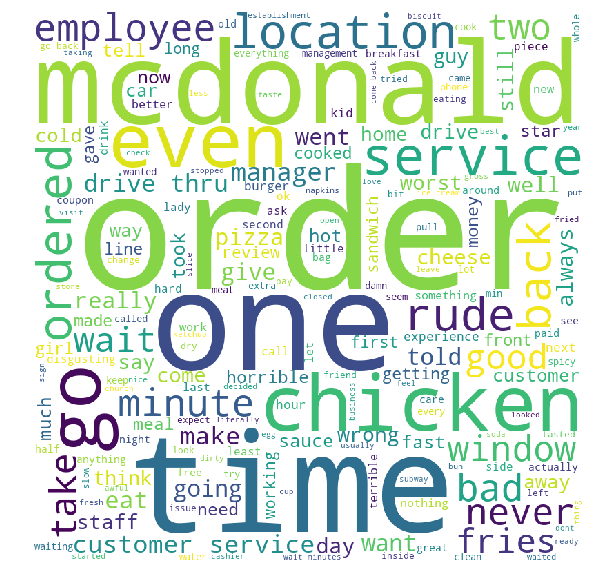

In [266]:
comment_words = ' '
#stopwords =set(STOPWORDS) 

# iterate through the csv file 
for val in bustipreview1star.text: 
    # typecaste each val to string 
    val = str(val) 

    # split the value 
    tokens = val.split()
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
    
    for words in tokens: 
        comment_words = comment_words + words + ' '

wordcloud = WordCloud(width = 800, height = 800,
                      background_color ='white',
                      stopwords=stopwords,
                      min_font_size = 10).generate(comment_words)
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0)
plt.show()

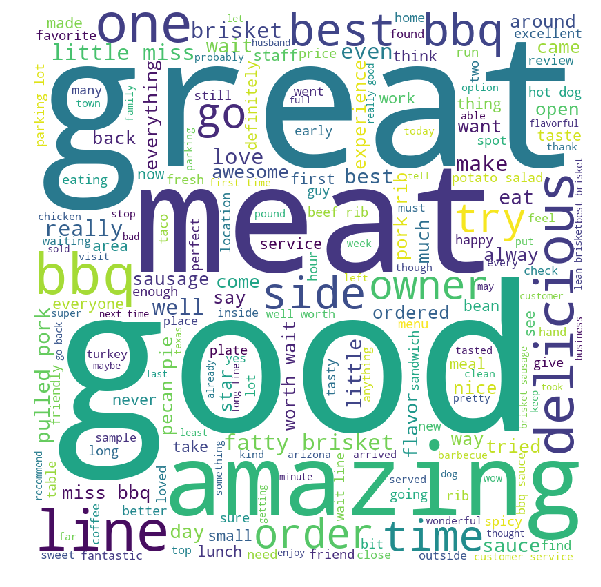

In [267]:
comment_words = ' '
#stopwords =set(STOPWORDS) 

# iterate through the csv file 
for val in bustipreview5star.text: 
    # typecaste each val to string 
    val = str(val) 

    # split the value 
    tokens = val.split()
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
    
    for words in tokens: 
        comment_words = comment_words + words + ' '

wordcloud = WordCloud(width = 800, height = 800,
                      background_color ='white',
                      stopwords=stopwords,
                      min_font_size = 10).generate(comment_words)
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0)
plt.show()

In [394]:
def word_count(text_string):
    '''Calculate the number of words in a string'''
    return len(text_string.split())


In [322]:
af = Afinn()
sentiment1_scores = [af.score(i) for i in bustipreview1star['text']]
sentiment1_category = ['positive' if score > 0 
                          else 'negative' if score < 0 
                              else 'neutral' 
                                  for score in sentiment_scores]
bustip1star = pd.DataFrame([list(bustipreview1star['business_id']),list(bustipreview1star['cat']),
                      sentiment_scores,sentiment_category]).T
bustip1star.columns = ['business_id','cat','sentiment1_score','sentiment1_category']
bustip1star.groupby(['business_id','cat']).describe()
#df = pd.DataFrame([list(news_df['news_category']), sentiment_scores, sentiment_category]).T
#df.columns = ['news_category', 'sentiment_score', 'sentiment_category']
#df['sentiment_score'] = df.sentiment_score.astype('float')
#df.groupby(by=['news_category']).describe()

sentiment1_category                   \
                                                    count unique       top   
business_id            cat                                                   
0BaMoKDVNv-MP84BQ9EK9A Burgers                         14      1  positive   
5cFGfnrVgmK-jqQWlq1Xrg Pizza                            3      1  positive   
Buoax_u7glzilOwKEwGlAQ Burger                           5      1  positive   
DbDnkoaPM_znq_2j2CXrQQ Burger                           5      2  positive   
FecWyJGnrIk5AYrR7C67xg Burgers                          6      2  positive   
G4XcXQhdS9Pt39bVDdfVCg Burgers                         20      3  positive   
I5Xxk3yWjCJdJb74iWFZzg Burgers                         19      2  positive   
IP-wtj3oAlz4uy-foRFEqQ Chicken                         15      2  positive   
J8mVsADcV_YvK3Mbw5Zfpg Sandwiches                       6      1  positive   
LqnKUCoiQksIPaO0qFkuGg Pizza                            6      1  positive   
Lvr6DdVkFI8IMGfRvUcXQA Pizza                            5      1  positive   
TAyCOYufOJ4OtxyHqfdlfA Burgers                          6      1  positive   
UijRV_R2aU8-V3aAx2ffxQ Burgers                         12      2  positive   
ViFDeMpfxe0EdIgOhX48Kw Chinese                          6      1  positive   
aRRV_ZbRiD65SIi7vAY-iA Indian                           3      1  positive   
bH3xVTnb_5w6k7ILK82Kaw Burger                           9      1  positive   
bT8rUptbdDGVwdTIMYz8Ow American (New)                   5      1  positive   
d3FAxA8Su34pGHjaIcl5lw Mexican                          8      1  positive   
dC2Uku3Q41gSTjc2WnZZAA Pizza                            5      1  positive   
dhFkEczL05Z2kbrNAPRViA Sandwiches                       9      3  positive   
fK5pISvzFanBY_W9D3C3rg Burgers                          9      1  positive   
hKQe1UsEbeo-qM1Vc8m23g Japanese                         4      1  positive   
n9mxpYKigTM6llGAChlAng Burgers                          7      1  positive   
rDMptJYWtnMhpQu_rRXHng Burgers                         18      1  positive   
tLZ_pvZaFlsIy18ssrm-7g Burgers                          5      2  positive   
uCO6aHdTqWwcPAU7bYih3Q Chicken                          9      1  positive   
ubP4xKtsJx2eW2cKAcy9gA Burgers                          6      1  positive   
yTKJW4g7o41wIi961WgYPA Chicken                          8      2  positive   

                                           sentiment1_score                    
                                      freq            count unique   top freq  
business_id            cat                                                     
0BaMoKDVNv-MP84BQ9EK9A Burgers          14             14.0   10.0  14.0  2.0  
5cFGfnrVgmK-jqQWlq1Xrg Pizza             3              3.0    3.0  11.0  1.0  
Buoax_u7glzilOwKEwGlAQ Burger            5              5.0    5.0  22.0  1.0  
DbDnkoaPM_znq_2j2CXrQQ Burger            3              5.0    5.0   6.0  1.0  
FecWyJGnrIk5AYrR7C67xg Burgers           5              6.0    6.0   5.0  1.0  
G4XcXQhdS9Pt39bVDdfVCg Burgers          18             20.0   16.0  16.0  2.0  
I5Xxk3yWjCJdJb74iWFZzg Burgers          18             19.0   12.0  17.0  3.0  
IP-wtj3oAlz4uy-foRFEqQ Chicken          14             15.0   13.0  16.0  2.0  
J8mVsADcV_YvK3Mbw5Zfpg Sandwiches        6              6.0    5.0   1.0  2.0  
LqnKUCoiQksIPaO0qFkuGg Pizza             6              6.0    5.0   3.0  2.0  
Lvr6DdVkFI8IMGfRvUcXQA Pizza             5              5.0    5.0  14.0  1.0  
TAyCOYufOJ4OtxyHqfdlfA Burgers           6              6.0    4.0  13.0  2.0  
UijRV_R2aU8-V3aAx2ffxQ Burgers          11             12.0   12.0  -1.0  1.0  
ViFDeMpfxe0EdIgOhX48Kw Chinese           6              6.0    6.0   6.0  1.0  
aRRV_ZbRiD65SIi7vAY-iA Indian            3              3.0    3.0   7.0  1.0  
bH3xVTnb_5w6k7ILK82Kaw Burger            9              9.0    8.0  14.0  2.0  
bT8rUptbdDGVwdTIMYz8Ow American (New)    5              5.0    4.0  16.0  2.0  
d3FAxA8Su34pGHjaIcl

In [314]:
#([bustip1star['sentiment1_score'] >=100])
[i for i in bustip1star['sentiment1_score'] if i > 100]

[108.0, 102.0, 102.0, 117.0]

In [277]:
#bustipreview1star.count()#233
#bustipreview2star.count()#5029
#bustipreview3star.count()#34461
#bustipreview4star.count()#152081
bustipreview5star.count()#2807

business_id                   2807
business_name                 2807
address                       2807
city                          2807
state                         2807
postal_code                   2807
latitude                      2807
longitude                     2807
business_star_rating          2807
review_count                  2807
is_open                       2807
categories                    2807
cat                           2804
Fast Food                     2807
Bars                          2807
Gluten-Free                   2807
Vegetarian                    2807
Vegan                         2807
Pizza                         2807
temp                          2807
chain                         2807
ByAppointmentOnly             2803
BusinessAcceptsCreditCards    2803
BusinessParking_garage        2803
BusinessParking_street        2803
BusinessParking_validated     2803
BusinessParking_lot           2803
BusinessParking_valet         2803
RestaurantsPriceRang

In [335]:
bustipreview2star.count()
af = Afinn()
sentiment2_scores = [af.score(i) for i in bustipreview2star['text']]
sentiment2_category = ['positive' if score > 0 
                          else 'negative' if score < 0 
                              else 'neutral' 
                                  for score in sentiment_scores]
bustip2star = pd.DataFrame([list(bustipreview2star['business_id']),list(bustipreview2star['cat']),sentiment2_scores,sentiment2_category]).T
bustip2star.columns = ['business_id','cat','sentiment2_score','sentiment2_category']
bustip2star.groupby(['business_id','cat']).describe()
#bustip2star.count()
#df = pd.DataFrame([list(news_df['news_category']), sentiment_scores, sentiment_category]).T
#df.columns = ['news_category', 'sentiment_score', 'sentiment_category']
#df['sentiment_score'] = df.sentiment_score.astype('float')
#df.groupby(by=['news_category']).describe()

sentiment2_category         \
                                                               count unique   
business_id            cat                                                    
-0WegMt6Cy966qlDKhu6jA American (New)                             89      3   
02ooNKJDjsE50KfmL0Rqdw Chicken                                    21      2   
0hp3WtPSxvmJVk3BNTfhHQ Burgers                                    21      1   
1buqH6E5R2jPOrTQDF6sFQ Burgers                                     6      1   
1r9lpt5r9l4uJxLLyt6QBw Burgers                                    47      3   
1ytwQT_hlhoxvgDzts4Osg Sandwiches                                  7      2   
2ADoawEfSAZpnQSwVEo5Ig Ice Cream & Frozen Yogurt                  20      2   
2F2xrnxCJ_WdXfWGxJcn_g Pizza                                      13      1   
2KIlQsIHwYMkuwA0T4OKrw Pizza                                      15      1   
2SHu52w_w4Z4ACq-vx3a-Q Tex-Mex                                    53      3   
2cnkFsZCMp2iVEzrkj2QAw Chicken                                     7      1   
2eWOFDYAfYdFIyxZEEcnAw Coffee & Tea                                5      1   
2fY8CEOjXUkIBz3cgXZJQQ Burgers                                    10      1   
3TintmVPo4Xu2drJ_iRpRQ American (New)                             17      1   
3xI0ToitrAJkrUSH4gbmCA Sandwiches                                 11      3   
403dr0KtTbRibcWEA7h0WA American (New)                             14      2   
45F5VaVlvrrtFikPa2v-tQ Ice Cream & Frozen Yogurt                   4      2   
4NpySSkznGaRVye30Pvdzg Pizza                                      57      3   
4_Ye_9x3dyMK-cfCBZrBRg Pizza                                      35      2   
5KAy9aeb4z2hSrPcMg3K0g Pizza                                       4      2   
5_MYcQWzKLiFYh0cUPrgNA Burger                                     11      2   
5aylLvgZVtI8H59uSClfxg Barbeque                                    7      1   
656XUeBmMzyvU62yYHptxQ Chinese                                     4      2   
66EYUS3iichq-Gn6KjgX2A Mexican                                    16      2   
67sq73gTdgHN0atGtIgDtA Chinese                                    29      1   
6SN1K-dWH5LoGHz4-SA1HQ Pizza                                      16      2   
6UUBVPqLLHpwLnDSL0jMuw Burgers                                    23      2   
6VZ4T_BnTl8swN-g06ZVYg Mexican                                     6      1   
6eUJ3BbrP7tsEKwYhMI4_Q Chinese                                    31      2   
6hfvVrOMmYapWGS1PN0b2w American (New)                              5      1   
...                                                              ...    ...   
rPY4bukI1QdfJc-1OCAwLg Burgers                                     0      0   
s6oqSa91yXeKXe5yMpV7dQ Burgers                                     0      0   
shKAREmZeftRe92aWJd4fQ Burger                                      0      0   
smdGDx5PS2Nt67FXYAQSUA Pizza                                       0      0   
tHaySMUc5u2a_71vfZG-0A Burger                                      0      0   
tSJaZL5X81j2k-GqtpBM_w Pizza                                       0      0   
uO7KbFyiMhhgFJNEDX_new Pizza                                       0      0   
uUIYh3iKyYKzbhl7ORYxVA Pizza                                       0      0   
urgviU4CGLGVLKTahwuzVg Pizza                                       0      0   
v3z_rK2cFteZrLSh5zSqTg Sandwiches                                  0      0   
v7GshnmUytEe3tm-HOgpsw Burgers                                     0      0   
vEX-H92z50_krgEUQzrYfQ Burgers                                     0      0   
vFnzV9uy9nEXFQgkSuv_AQ Indian                                      0      0   
wOfoU-QWGudP8kmBDNwQnA Burgers                                     0      0   
wZ3MABp8WcSHfZrlEQa5dw Chinese                                     0      0   
wsZbtXGBb1QwycUppFJoCA American (New)                              0      0   
x8Sp-h-oR5WdzoG5WEsHnQ Chicken                                     0      0   
xEpIUFKBHgnq3pXVaxNg

In [354]:
af = Afinn(language='en')

sentiment3_scores = [af.score(i) for i in bustipreview3star['text']]
sentiment3_category = ['positive' if score > 0.0
                          else 'negative' if score < 0.0
                              else 'neutral' 
                                  for score in sentiment_scores]
bustip3star = pd.DataFrame([list(bustipreview3star['business_id']),list(bustipreview3star['cat']),listbustipreview3star['text'],
                            sentiment3_scores,sentiment3_category]).T
bustip3star.columns = ['business_id','cat','sentiment3_score','sentiment3_category']
bustip3star = pd.DataFrame([list(bustipreview3star['business_id']),list(bustipreview3star['cat']),list(bustipreview3star['text']),
                            sentiment3_scores,sentiment3_category]).T
bustip3star.columns = ['business_id','cat','text','sentiment3_score','sentiment3_category']

In [396]:
af = Afinn(language='en')

sentiment_scores = [af.score(i) for i in bustipreview_df['text']]
sentiment_category = ['positive' if score > 0.0
                          else 'negative' if score < 0.0
                              else 'neutral' 
                                  for score in sentiment_scores]


KeyboardInterrupt: 

In [ ]:
bustiprev = pd.DataFrame([list(bustipreview_df['business_id']),list(bustipreview_df['cat']),list(bustipreview_df['text']),
                            sentiment_scores,sentiment_category]).T
bustiprev.columns = ['business_id','cat','sentiment_score','sentiment_category']


In [ ]:
bustiprev['word_count'] = [word_count(i) for i in bustipreview3star['text']]
bustiprev['sentiment_scores_adjusted'] = bustiprev['sentiment_score']/bustiprev['word_count'] *100
bustiprev['sentiment_category_adjusted'] = ['positive' if score > 0.0
                          else 'negative' if score < 0.0
                              else 'neutral' 
                                  for score in bustiprev['sentiment_scores_adjusted']]
#bustip3star['sentiment3_scores_adjusted'].max()
#bustip3star.groupby(['business_id','cat']).describe()


In [ ]:
#bustiprev.groupby(['business_id','cat'])['text','sentiment_scores_adjusted','sentiment_category_adjusted'].describe()
bustiprev.groupby(['cat'])['text','sentiment_scores_adjusted','sentiment_category_adjusted'].describe()


In [378]:
bustip3star = pd.DataFrame([list(bustipreview3star['business_id']),list(bustipreview3star['cat']),list(bustipreview3star['text']),
                            sentiment3_scores,sentiment3_category]).T
bustip3star.columns = ['business_id','cat','text','sentiment3_score','sentiment3_category']

In [391]:
bustip3star['word3_count'] = [word_count(i) for i in bustipreview3star['text']]
bustip3star['sentiment3_scores_adjusted'] = bustip3star['sentiment3_score']/bustip3star['word3_count'] *100
bustip3star['sentiment3_category_adjusted'] = ['positive' if score > 0.0
                          else 'negative' if score < 0.0
                              else 'neutral' 
                                  for score in bustip3star['sentiment3_scores_adjusted']]
#bustip3star['sentiment3_scores_adjusted'].max()
#bustip3star.groupby(['business_id','cat']).describe()


In [460]:
(bustip3star.groupby(['cat'])['sentiment3_scores_adjusted','sentiment3_category_adjusted'].describe()).to_csv('C:/Users/Ric/Desktop/000_MY_WORKDIRECTORY/python/capstone yelp/3starafinn.csv',sep=',',index= False)
#bustip3star.groupby(['cat'])['sentiment3_category_adjusted'].describe()[]
#bustip3star['cat'].value_counts()

PermissionError: [Errno 13] Permission denied: 'C:/Users/Ric/Desktop/000_MY_WORKDIRECTORY/python/capstone yelp/3starafinn.csv'

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

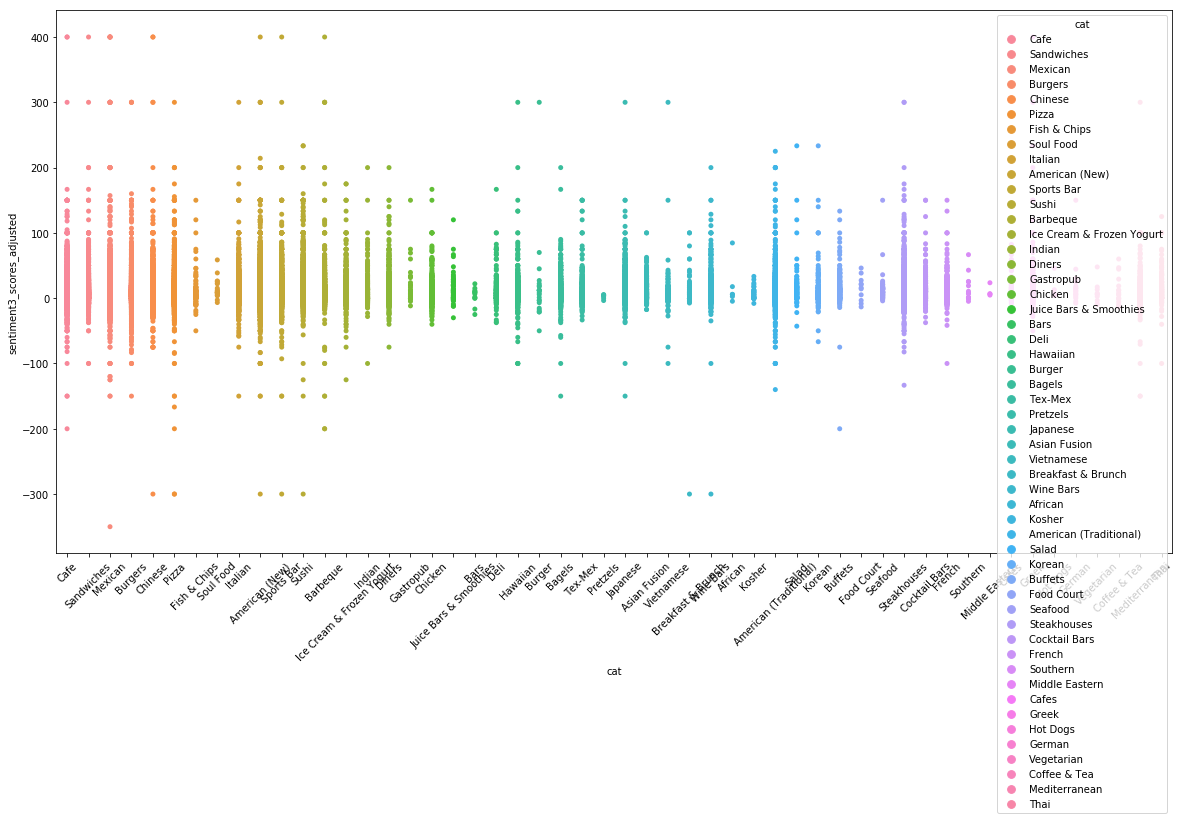

In [466]:
#f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
plt.figure(figsize=(20,10))
sp = sns.stripplot(x='cat', y="sentiment3_scores_adjusted", 
                   hue='cat', data=bustip3star)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
#sp.set_xticklabels(sp.get_xticklabels(), rotation=40)
#sp.set_xticklabels(sp.get_xticklabels(), rotation=40, ha="right")

#bp = sns.boxplot(x='news_category', y="sentiment_score", 
 #                hue='news_category', data=df, palette="Set2", ax=ax2)
#t = f.suptitle('Visualizing Sentiment Score by Categories', fontsize=14)

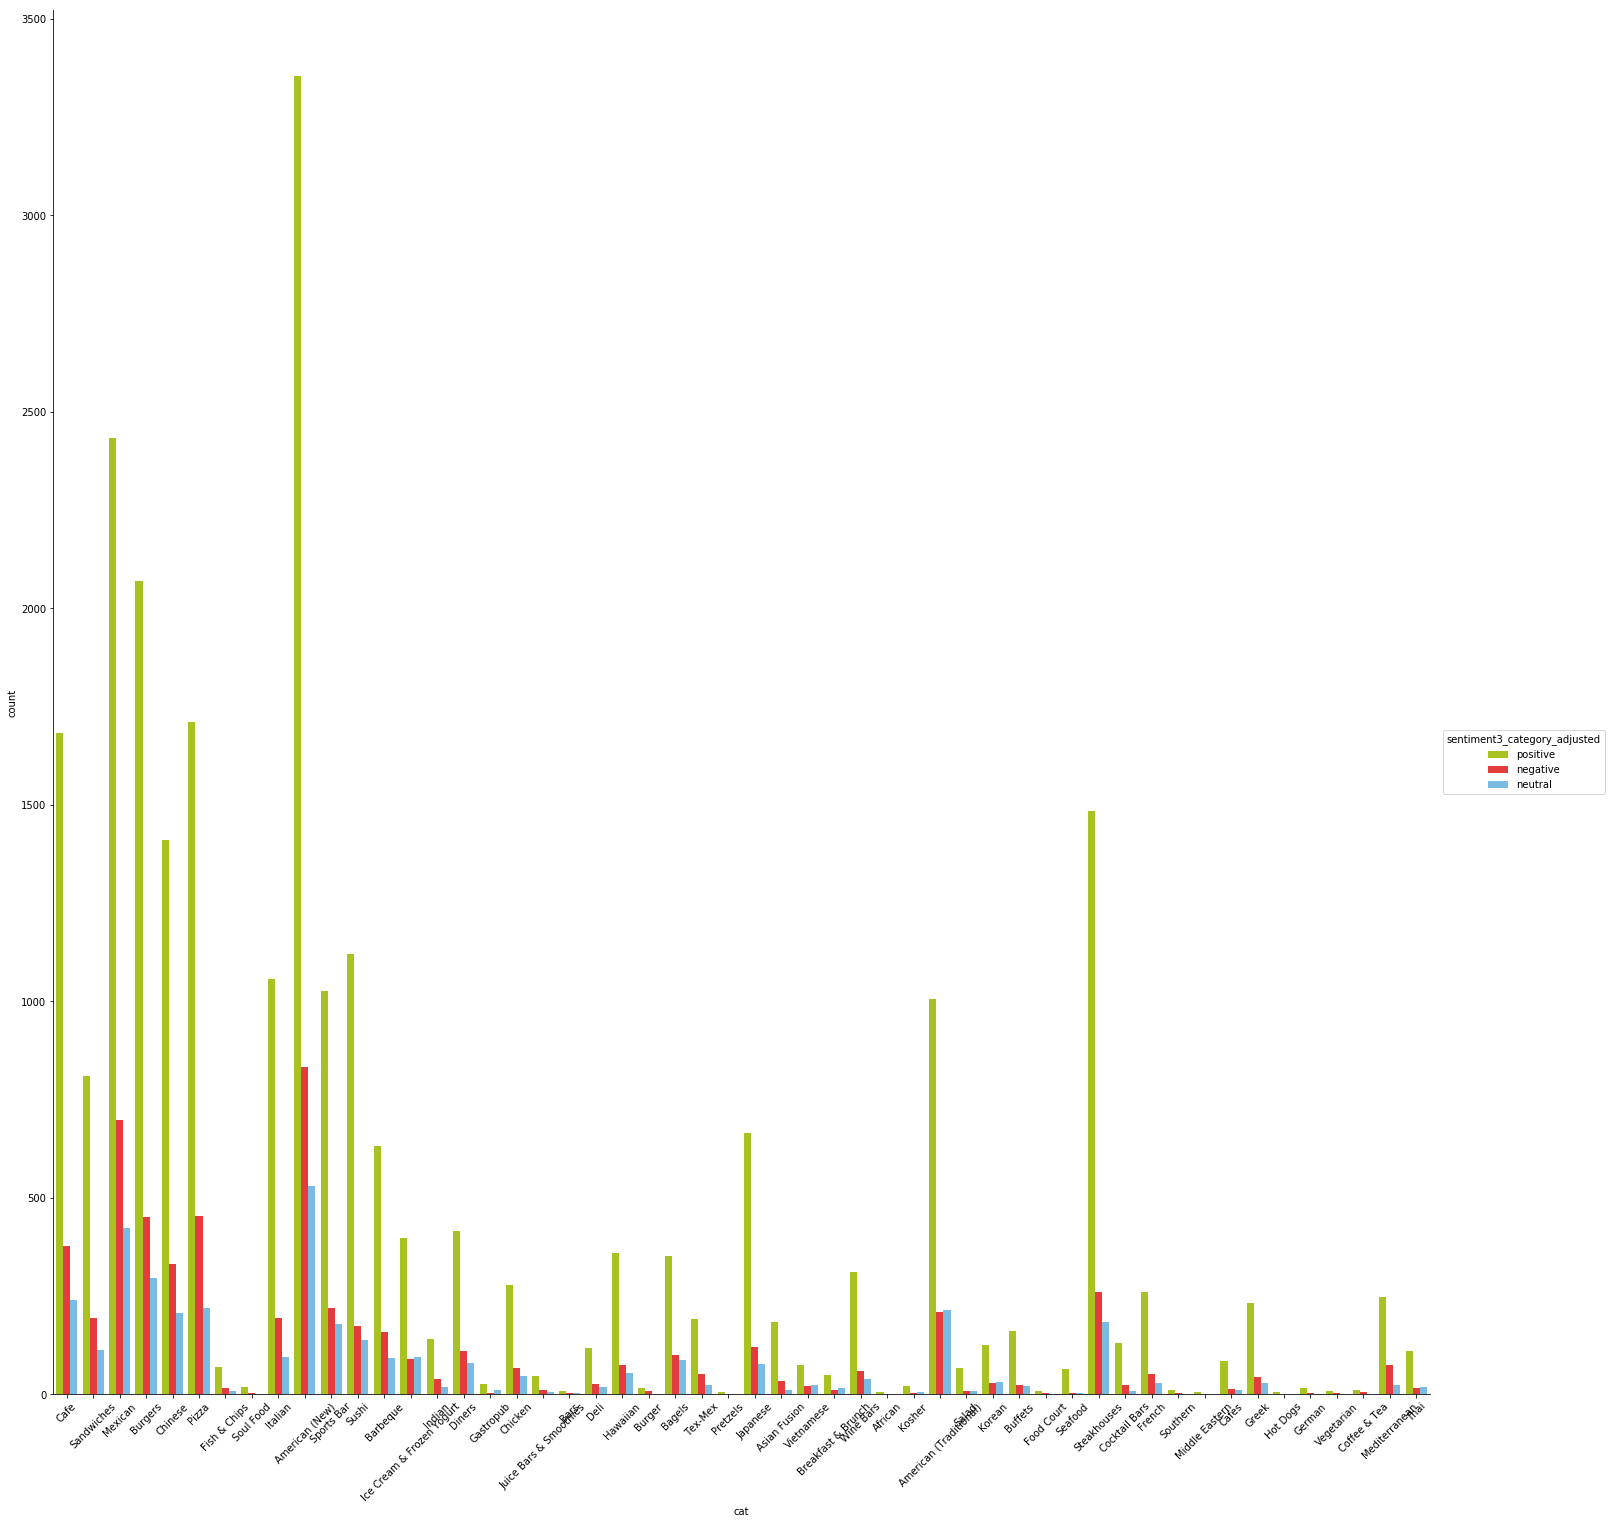

In [467]:
plt.figure(figsize=(200,200))
fc = sns.factorplot(x="cat", hue="sentiment3_category_adjusted", 
                    data=bustip3star, kind="count", 
                    palette={"negative": "#FE2020", 
                             "positive": "#BADD07", 
                             "neutral": "#68BFF5"},size=20, aspect=1)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
#fc.set_xticklabels(fc.get_xticklabels(), rotation=40, ha="right")
plt.savefig("C:/Users/Ric/Desktop/000_MY_WORKDIRECTORY/python/capstone yelp/factorplot3starrating.png")


In [393]:
#[i for i in bustip2star['sentiment2_score'] if i > 90]
max(bustip3star['sentiment3_scores_adjusted'])
#bustip3star[bustip3star['business_id']=='yDKmcWQ_Zycr4ekLV4CqFg']

400.0

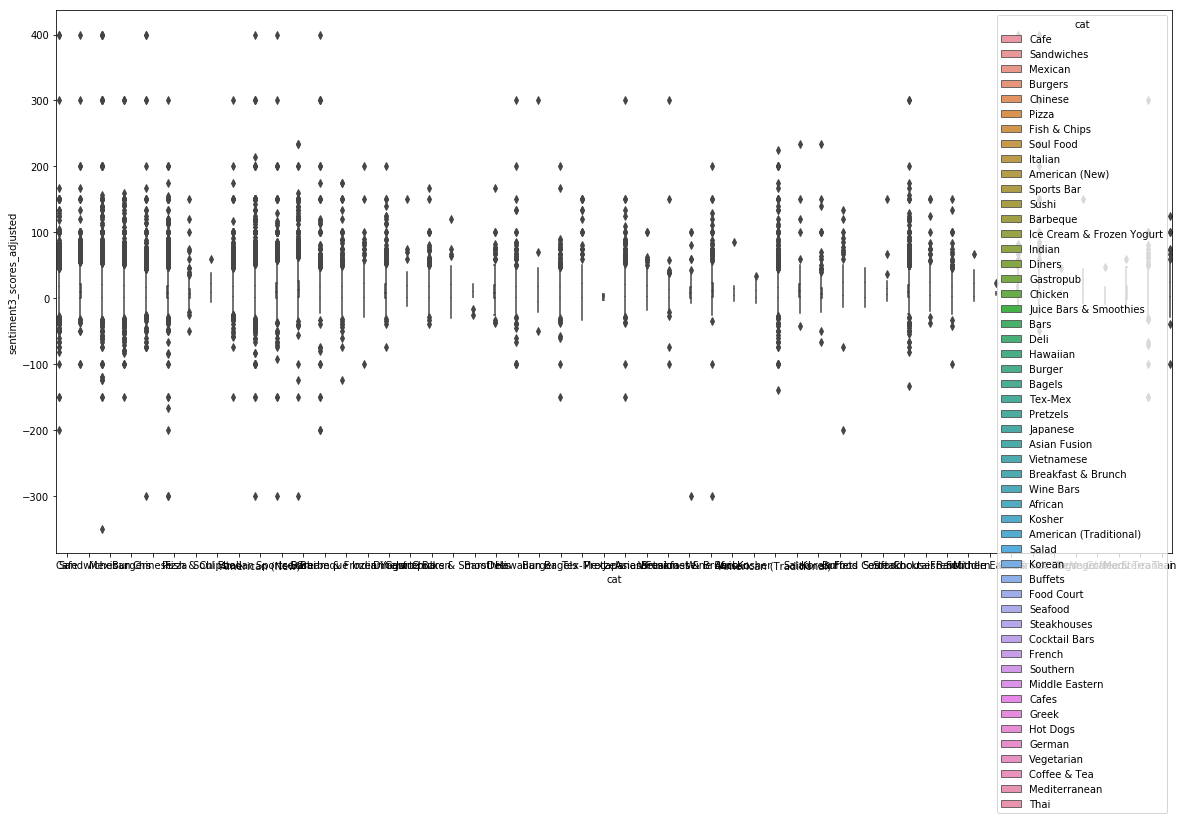

In [430]:
plt.figure(figsize=(20,10))
bustip3star['sentiment3_scores_adjusted'] = bustip3star['sentiment3_scores_adjusted'].astype(float)
bp = sns.boxplot(x='cat', y="sentiment3_scores_adjusted", hue='cat', data=bustip3star)

In [ ]:
af = Afinn()
sentiment4_scores = [af.score(i) for i in bustipreview4star['text']]
sentiment4_category = ['positive' if score > 0 
                          else 'negative' if score < 0 
                              else 'neutral' 
                                  for score in sentiment_scores]
bustip4star = pd.DataFrame([list(bustipreview4star['business_id']),list(bustipreview4star['cat']),sentiment4_scores,sentiment4_category]).T
bustip4star.columns = ['business_id','cat','sentiment4_score','sentiment4_category']
bustip4star.groupby(['business_id','cat']).describe()
#df = pd.DataFrame([list(news_df['news_category']), sentiment_scores, sentiment_category]).T
#df.columns = ['news_category', 'sentiment_score', 'sentiment_category']
#df['sentiment_score'] = df.sentiment_score.astype('float')
#df.groupby(by=['news_category']).describe()

In [ ]:
af = Afinn()
sentiment5_scores = [af.score(i) for i in bustipreview5star['text']]
sentiment5_category = ['positive' if score > 0 
                          else 'negative' if score < 0 
                              else 'neutral' 
                                  for score in sentiment_scores]
bustip5star = pd.DataFrame([list(bustipreview5star['business_id']),list(bustipreview4star['cat']),sentiment5_scores,sentiment5_category]).T
bustip5star.columns = ['business_id','cat','sentiment5_score','sentiment5_category']
bustip5star.groupby(['business_id','cat']).describe()
#df = pd.DataFrame([list(news_df['news_category']), sentiment_scores, sentiment_category]).T
#df.columns = ['news_category', 'sentiment_score', 'sentiment_category']
#df['sentiment_score'] = df.sentiment_score.astype('float')
#df.groupby(by=['news_category']).describe()

In [68]:
build_text(yelprev_df1)

,keywords,business_id,stars_x,stars_y,date,categories
0,"salad,cooky,time,im,chip,filling,love,soup,yes...",__aKnGBedQ51_hEc3D9ARw,3.0,3,2013-04-23,Sandwiches;Restaurants;Food;Bakeries;Juice Bar...
1,"salad,always,get,thai,chicken,sometimes,bowl,g...",__aKnGBedQ51_hEc3D9ARw,3.0,3,2014-02-06,Sandwiches;Restaurants;Food;Bakeries;Juice Bar...
2,"salad,ordering,line,process,station,sandwich,s...",__aKnGBedQ51_hEc3D9ARw,3.0,3,2014-03-18,Sandwiches;Restaurants;Food;Bakeries;Juice Bar...
3,"order,time,get,one,lunch,ordered,affordable,op...",__aKnGBedQ51_hEc3D9ARw,3.0,1,2015-01-14,Sandwiches;Restaurants;Food;Bakeries;Juice Bar...
4,"sandwich,back,order,wont,ever,come,came,waitin...",__aKnGBedQ51_hEc3D9ARw,3.0,1,2012-02-28,Sandwiches;Restaurants;Food;Bakeries;Juice Bar...
5,"cant,place,amazing,almost,every,salad,get,enou...",__aKnGBedQ51_hEc3D9ARw,3.0,4,2009-05-28,Sandwiches;Restaurants;Food;Bakeries;Juice Bar...
6,"task,feeling,know,busy,love,good,right,world,e...",__aKnGBedQ51_hEc3D9ARw,3.0,1,2014-02-24,Sandwiches;Restaurants;Food;Bakeries;Juice Bar...
7,"grilled,cheese,ill,keep,quick,forgot,food,sand...",__aKnGBedQ51_hEc3D9ARw,3.0,1,2015-09-21,Sandwiches;Restaurants;Food;Bakeries;Juice Bar...
8,"great,office,away,home,cater,impromptu,meeting...",__aKnGBedQ51_hEc3D9ARw,3.0,4,2015-11-30,Sandwiches;Restaurants;Food;Bakeries;Juice Bar...
9,"paradise,got,boyfriend,introduced,bakery,fan,c...",__aKnGBedQ51_hEc3D9ARw,3.0,4,2011-06-09,Sandwiches;Restaurants;Food;Bakeries;Juice Bar...


In [166]:
lemmatizer = WordNetLemmatizer()
 
def penn_to_wn(tag):
    """
    Convert between the PennTreebank tags to simple Wordnet tags
    """
    if tag.startswith('J'):
        return wn.ADJ
    elif tag.startswith('N'):
        return wn.NOUN
    elif tag.startswith('R'):
        return wn.ADV
    elif tag.startswith('V'):
        return wn.VERB
    return None
 
#def clean_text(text):
 #   text = text.replace("<br />", " ")
  #  text = text.decode("utf-8")
 
  #  return text
 
def swn_polarity(text):
    """
    Return a sentiment polarity: 0 = negative, 1 = positive
    """
 
    sentiment = 0.0
    tokens_count = 0
 
  #  text = clean_text(text)
 
 
    raw_sentences = sent_tokenize(text)
    for raw_sentence in raw_sentences:
        tagged_sentence = pos_tag(word_tokenize(raw_sentence))
 
        for word, tag in tagged_sentence:
            wn_tag = penn_to_wn(tag)
            if wn_tag not in (wn.NOUN, wn.ADJ, wn.ADV):
                continue
 
            lemma = lemmatizer.lemmatize(word, pos=wn_tag)
            if not lemma:
                continue
 
            synsets = wn.synsets(lemma, pos=wn_tag)
            if not synsets:
                continue
 
            # Take the first sense, the most common
            synset = synsets[0]
            swn_synset = swn.senti_synset(synset.name())
 
            sentiment += swn_synset.pos_score() - swn_synset.neg_score()
            tokens_count += 1
 
    # judgment call ? Default to positive or negative
    if not tokens_count:
        return 0
 
    # sum greater than 0 => positive sentiment
    if sentiment >= 0:
        return 1
 
    # negative sentiment
    return 0

In [167]:
[swn_polarity(i) for i in yelprev_df1['text']]

[0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1]

In [168]:
sentiment_polarity = [swn_polarity(i) for i in yelprev_df1['text']]
yelprev12 = pd.DataFrame([list(yelprev_df1['business_id']),list(yelprev_df1['cat']),sentiment_polarity]).T
yelprev12.columns = ['business_id','cat','sentiment_polarity']
yelprev12.groupby(['business_id','cat']).describe()

sentiment_polarity         \
                                                              count unique   
business_id            cat                                                   
-0WegMt6Cy966qlDKhu6jA American (New)                             1      1   
-0aIra_B6iALlfqAriBSYA Coffee & Tea                               1      1   
-0tgMGl7D9B10YjSN2ujLA Bars                                       1      1   
-1UMR00eXtwaeh59pEiDjA Cocktail Bars                              1      1   
-2isRNVb6PDuBagELL5EBw Mexican                                    1      1   
-8JaNeG3etLgOVyg2gOIiA Mexican                                    1      1   
-9eNGMp8XiygI8t8QFuFWw American (New)                             1      1   
-Bdw-5H5C4AYSMGnAvmnzw Cocktail Bars                              1      1   
-BxWyEIQ6wypT-37MzZizQ Burgers                                    1      1   
-o0xWAEO-C2oqlyt9TO8qg Seafood                                    1      1   
-raUM9T-1dKPiB5_vRmFYA Italian                                    1      1   
0-CXwwVL-u0tc0FOuSExWQ Cafes                                      1      1   
01Gav7vnilRwSVm3WwkAtA American (Traditional)                     1      1   
01cFftHZc98jNJfJrLEJ5g Sandwiches                                 1      1   
01xXe2m_z048W5gcBFpoJA Burgers                                    1      1   
02GctEso08hyhQpkqOftsw Cafe                                       1      1   
02eESJZNF3qigrJ3GNRgIQ Mexican                                    1      1   
02ooNKJDjsE50KfmL0Rqdw Chicken                                    1      1   
02zH3RnRvBWfMoBUqtzfsg Soul Food                                  1      1   
042IHd5KjHiMuBtGtugO_g Burgers                                    1      1   
04Iq42i8lm50Lvdj1j3DCQ Italian                                    1      1   
06PiQOUehVOYtDcZRWrA5A Pizza                                      1      1   
06lCNuSrCnaU6eq0EV4PYg Burgers                                    1      1   
079CV1EE5WLdQqVEVYFeHQ Chinese                                    1      1   
0859wfd1BQHG46Zpwhc0ZQ Wine Bars                                  1      1   
08_PxnpSJO4Rxt05EYaAxg Delis                                      1      1   
09LYxY5D4GcKc0Tvs4K_gw Coffee & Tea                               1      1   
0B_aEPeZjrXs6T7vS3arrA Wine Bars                                  1      1   
0BaMoKDVNv-MP84BQ9EK9A Burgers                                    1      1   
0Buxoc0cRqjpvkezo3bqog Japanese                                   1      1   
...                                                             ...    ...   
30xoqX9VRA_hH5x1QgONEA Pizza                                      1      1   
333W59XcrXZsJlnBAAx5mQ Mexican                                    1      1   
34VuBMNaG9nJiyqsnoEgPg Sushi                                      1      1   
355zerURpj4IMs2no238_A Asian Fusion                               1      1   
3Alq2Er28QVsdxGJlQgVkg Ice Cream & Frozen Yogurt                  1      1   
3BGzRYh6GQbZz3LGAGb-sQ Sports Bar                                 1      1   
3ByGQOVgds2YEu6kzl-XEQ Sports Bar                                 1      1   
3C5Z9homtzkWHouH2BHXYQ Mexican                                    1      1   
3CBLxydJU6CFRMGhu9b-sw American (New)                             1      1   
3G_wGIblXDNRYg4xIe9VZA Chinese                                    1      1   
3Hu-IPhq5I_jyb3YfeHpGQ Sandwiches                                 1      1   
3IWgxsZ8E49hNsY3qSvdZw Burgers                                    1      1   
3K9u2FpHG9b7tWogqyEyWQ Indian                                     1      1   
3KrZFsROpOTUdPz8MwXPuA Deli                                       1      1   
3QQEc5QUP-h6LCkUZQEYQw Sports Bar                                 1      1   
3Ru1_F8GoUcV-QwhX378hA Asian Fusion                               1      1   
3TintmVPo4Xu2drJ_iRpRQ American (New)                             1      1   
3U__XOTBFptjhBeHrPGqrg Pizza                                      1    

In [471]:
def vaderize(df, textfield):
    '''Compute the Vader polarity scores for a textfield. 
    Returns scores and original dataframe.'''

    analyzer = SentimentIntensityAnalyzer()

    print('Estimating polarity scores for %d cases.' % len(df))
    sentiment = df[textfield].apply(analyzer.polarity_scores)

    # convert to dataframe
    sdf = pd.DataFrame(sentiment.tolist()).add_prefix('vader_')

    # merge dataframes
    df_combined = pd.concat([df, sdf], axis=1)
    return df_combined

In [472]:
df_vaderized = vaderize(bustipreview3star, 'text')

Estimating polarity scores for 34461 cases.
